# Introduction to Artificial Neural Networks with Keras
Based on the notebook of the same name by [Aurelien Geron](https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb).

In this notebook, we'll take the theoretical concepts of the past few weeks and apply them using the [Keras](https://keras.io/) library. Keras is a high-level wrapper that was originally designed to make Tensorflow easier to use, then was merged into Tensorflow, and now is a general high-level wrapper on Tensorflow, PyTorch, and JAX frameworks. For many "basic" neural network tasks, Keras is a great choice.

## Objectives
- Understand the basic structure of a neural network
- Understand how to work with Keras
- Build and train a simple classifier
- Explore some more features of the Keras/Tensorflow ecosystem

First we'll load the necessary libraries and make sure we have the right versions.

In [1]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import numpy as np
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt

## Load and explore the data
We'll be working with a very clean "hello world" type of dataset, but it's still a good idea to take a peek.

`tf.keras.datasets` has a number of built-in popular datasets used for teaching exercises (like this one), benchmarking, and even some new research. The original version of this notebook used the Fashion MNIST dataset, but we'll use the "classic" MNIST dataset to relate things back to the 1989 paper that we read this week (or the 1998 version that I posted by accident, which is actually the origin of the MNIST dataset).

The [load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) method returns a tuple of two tuples, one for the training data and one for the test data.

In [2]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist.load_data() # I wish it was always this easy
(X_train_full, y_train_full), (X_test, y_test) = mnist

# further split the training data into training and validation sets
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [3]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [4]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [5]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

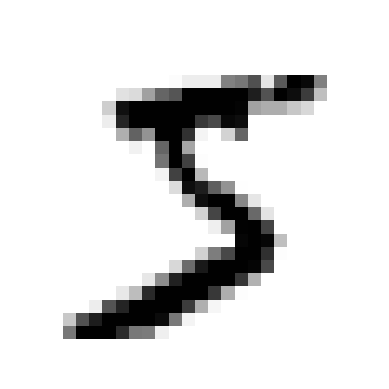

In [6]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [7]:
y_train

array([5, 0, 4, ..., 0, 4, 0], dtype=uint8)

Let's take a look at a sample of the images in the dataset:

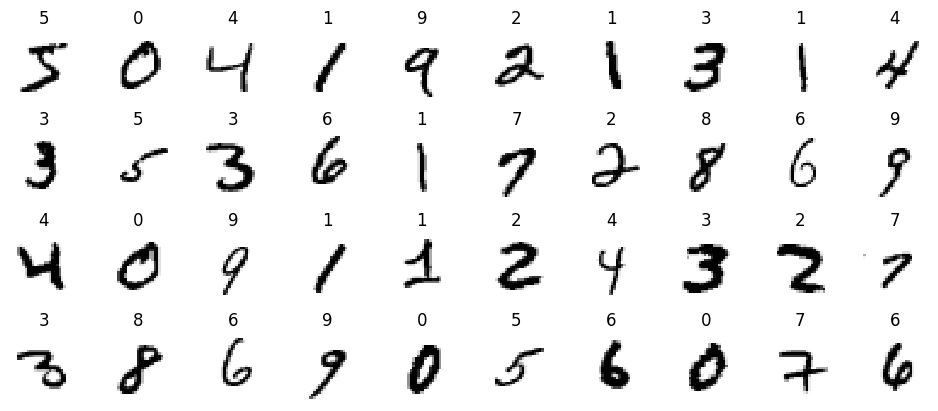

In [8]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

Okay, that looks reasonable. What about the distribution of the classes? Let's plot some histograms to make sure the train/test/validation sets are balanced.

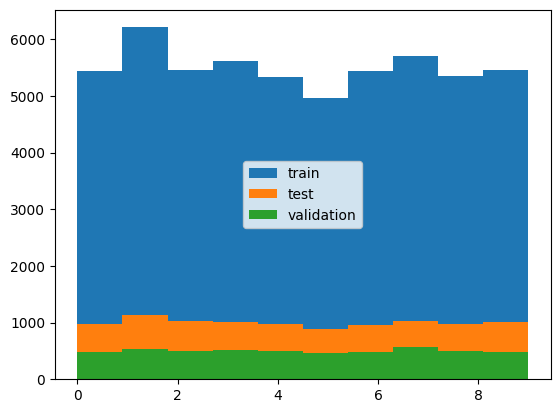

In [9]:
plt.hist(y_train, bins=10, label='train')
plt.hist(y_test, bins=10, label='test')
plt.hist(y_valid, bins=10, label='validation')
plt.legend(loc='center')

Looks like a slight overrepresentation of 1s, but nothing egregious.

## Creating the model
Keras v3 has [three ways of building models](https://keras.io/api/models/model/): sequential, functional, and subclassing. Keras v2 (the one incorporated into Tensorflow) has only sequential and functional. The sequential API is the simplest, but only works when you're building a simple stack of layers.

For this model, we'll use 2 fully-connected layers (a departure from the original 1989 paper) and a softmax output layer with one neuron per class. The input layer will take our scaled 28x28 images and flatten them into a 1D array.

❓ **Discussion questions**: 
- Why was the "pyramid" shape (many neurons in the first layer, fewer in the second, even fewer in the third, etc.) popular early on?
- What is the current trend in selecting the number of neurons in a layer?
- What is better, more layers or more neurons per layer?

In [10]:
tf.random.set_seed(42) # for reproducability
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 80)                62800     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dense_3 (Dense)             (None, 80)                6480      
                                                                 
 dense_4 (Dense)             (None, 10)                810       
                                                                 
Total params: 83050 (324.41 KB)
Trainable params: 83050 

Now that we've defined the model, we can access each layer using the `layers` attribute and look at various things like the weights and biases.

In [12]:
w1, b1 = model.layers[1].get_weights()
print(w1.shape)
print("First 10 weights: ", w1[:10, 0])
print("First 10 biases: ", b1[:10])


(784, 80)
First 10 weights:  [-0.00479225  0.06634887 -0.06760129 -0.04249378 -0.01838458 -0.06117558
 -0.02621822 -0.05674475 -0.05654129  0.03586197]
First 10 biases:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


This shows that the weights are randomly initialized, while biases are initialized to 0. This default behaviour (among other things) can be changed - [Reading the docs](https://keras.io/api/layers/initializers/) is always a good idea!

### Compiling the model
[Compiling the model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) is a bit of a misnomer - it's not compiling anything in the CS sense. A better word might be "configuring" the model. This is where you specify the loss function, the optimizer, and any metrics you want to track.

❓ **Discussion questions**: 
- What should we use for loss, optimizer, and metrics? What are the options?
- What is the difference between metrics and loss?
- What is the difference between categorical and sparse categorical crossentropy?

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

### Training and evaluating the model

In [14]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


1719/1719 [==============================] - 4s 2ms/step - loss: 0.7975 - accuracy: 0.7596 - val_loss: 0.2616 - val_accuracy: 0.9294
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2845 - accuracy: 0.9169 - val_loss: 0.1938 - val_accuracy: 0.9464
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2153 - accuracy: 0.9367 - val_loss: 0.1526 - val_accuracy: 0.9582
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1767 - accuracy: 0.9479 - val_loss: 0.1396 - val_accuracy: 0.9618
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1495 - accuracy: 0.9549 - val_loss: 0.1190 - val_accuracy: 0.9688
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1302 - accuracy: 0.9612 - val_loss: 0.1266 - val_accuracy: 0.9620
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1150 - accuracy: 0.9656 - val_loss: 0.1035 - val_accurac

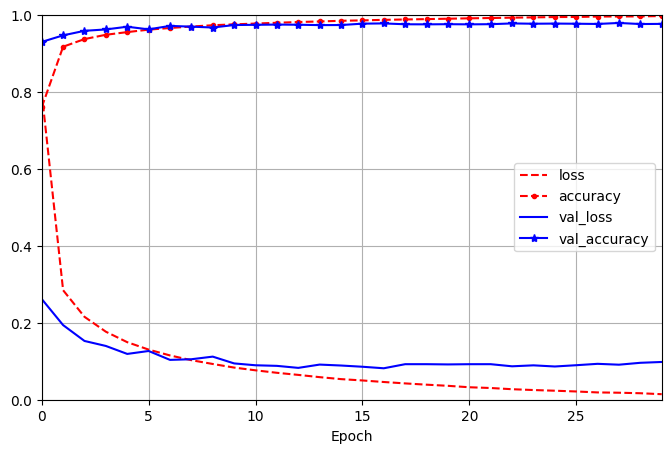

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend()

❓ **Discussion questions**: 
- Does this seem like a good model?
- How is the validation accuracy lower than training at the beginning?

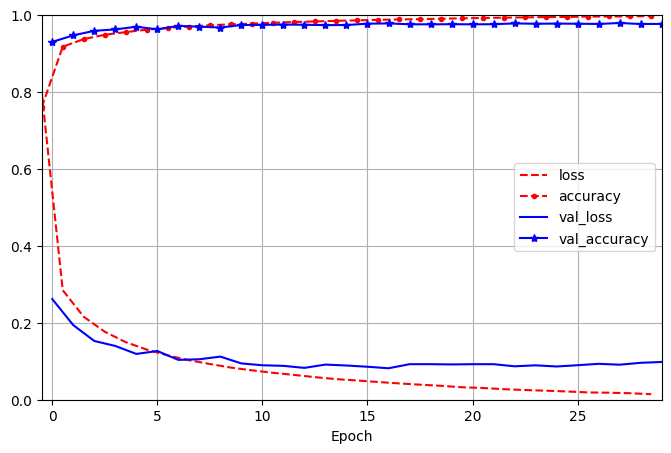

In [16]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend()
plt.grid()
plt.show()

In [17]:
# Final evaluation
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0955 - accuracy: 0.9745


[0.0955466628074646, 0.9745000004768372]

### Using the model to make predictions
The accuracy looks great, but let's see how it behaves with some subjective examples.

In [18]:
X_new = X_test[:5]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 95ms/step


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

❓ **Discussion questions**:
- What are those 1s and 0s (and close to them)?
- How can we map from the model output back to the class label?


In [19]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([7, 2, 1, 0, 4], dtype=int64)

In [20]:
y_new = y_test[:5]
y_new

array([7, 2, 1, 0, 4], dtype=uint8)

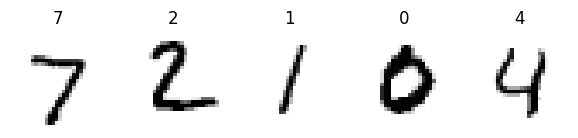

In [21]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(y_test[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We can go back and mess with the various parts of the model to see how it affects things, but 97.8% accuracy is pretty good. Of course, that was the MNIST dataset, which has been studied by many people for many years. Let's build a model for a different dataset.